# Fruit and Vegetable Classification
## \# Class activation heatmap for image classification
## \# Grad-CAM class activation visualization

Having 3825 images of 36 different fruits/vegetables

![fruit vegetable](https://i.imgur.com/KUAcIQD.jpeg)

<h1>Table of contents</h1>
 

<ul>
<li><a href="#1"><strong>1. Loading and preprocessing</strong></a>
</ul>
    
<ul>
<li><a href="#2"><strong>2. Load the Images with a generator and Data Augmentation</strong></a>
</ul>

<ul>
<li><a href="#3"><strong>3. Train the model</strong></a>
</ul>

<ul>
<li><a href="#4"><strong>4. Visualize the result</strong></a>
</ul>

<ul>
<li><a href="#5"><strong>5. Class activation heatmap for image classification</strong></a>
</ul>

# Context

This dataset contains images of the following food items:

- **fruits**: banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango
- **vegetables**: cucumber, carrot, capsicum, onion, potato, lemon, tomato, raddish, beetroot, cabbage, lettuce, spinach, soy bean, cauliflower, bell pepper, chilli pepper, turnip, corn, sweetcorn, sweet potato, paprika, jalepeño, ginger, garlic, peas, eggplant

# Content
This dataset contains three folders:

- train (100 images each)
- test (10 images each)
- validation (10 images each)
each of the above folders contains subfolders for different fruits and vegetables wherein the images for respective food items are present# Context

This dataset contains images of the following food items:

- **fruits**: banana, apple, pear, grapes, orange, kiwi, watermelon, pomegranate, pineapple, mango
- **vegetables**: cucumber, carrot, capsicum, onion, potato, lemon, tomato, raddish, beetroot, cabbage, lettuce, spinach, soy bean, cauliflower, bell pepper, chilli pepper, turnip, corn, sweetcorn, sweet potato, paprika, jalepeño, ginger, garlic, peas, eggplant

# Content
This dataset contains three folders:

- train (100 images each)
- test (10 images each)
- validation (10 images each)
each of the above folders contains subfolders for different fruits and vegetables wherein the images for respective food items are present


# 1. Loading and preprocessing<a class="anchor" id="1"></a><a class="anchor" id="1"></a>

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

def get_image_filepaths(directory, extensions=('.jpg', '.jpeg', '.png')):
    """
    Retrieve image file paths from a directory with specific extensions.
    """
    filepaths = list(directory.glob(r'**/*.*'))
    # Lọc chỉ các tệp có định dạng hợp lệ
    valid_filepaths = [path for path in filepaths if path.suffix.lower() in extensions]
    return valid_filepaths

# Tạo danh sách filepaths cho training, testing, và validation
train_dir = Path('D:/Fruit and Vegetable Classification/train')
train_filepaths = get_image_filepaths(train_dir)

test_dir = Path('D:/Fruit and Vegetable Classification/test')
test_filepaths = get_image_filepaths(test_dir)

val_dir = Path('D:/Fruit and Vegetable Classification/validation')
val_filepaths = get_image_filepaths(val_dir)

# Kiểm tra số lượng file trong từng tập dữ liệu
print("Number of training images:", len(train_filepaths))
print("Number of testing images:", len(test_filepaths))
print("Number of validation images:", len(val_filepaths))

def proc_img(filepaths):
    """
    Create a DataFrame with the filepaths and labels of the pictures.
    """
    # Trả về DataFrame rỗng nếu không có file nào
    if not filepaths:
        return pd.DataFrame(columns=["Filepath", "Label"])
    
    # Lấy nhãn từ tên thư mục cha của mỗi file
    labels = [path.parent.name for path in filepaths]
    
    # Tạo DataFrame từ filepaths và labels
    df = pd.DataFrame({
        "Filepath": [str(path) for path in filepaths],
        "Label": labels
    })
    
    # Trộn ngẫu nhiên và đặt lại chỉ số
    df = df.sample(frac=1).reset_index(drop=True)
    return df

# Tạo DataFrame cho tập train, test, và validation
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)




Number of training images: 3115
Number of testing images: 359
Number of validation images: 351


In [5]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3115

Number of different labels: 36

Labels: ['banana' 'corn' 'pineapple' 'soy beans' 'kiwi' 'turnip' 'lettuce'
 'raddish' 'spinach' 'capsicum' 'pear' 'onion' 'lemon' 'garlic' 'beetroot'
 'eggplant' 'jalepeno' 'watermelon' 'cucumber' 'mango' 'carrot'
 'cauliflower' 'sweetpotato' 'peas' 'potato' 'chilli pepper' 'cabbage'
 'apple' 'sweetcorn' 'bell pepper' 'grapes' 'tomato' 'ginger'
 'pomegranate' 'orange' 'paprika']


In [6]:
# DataFrame với các đường dẫn tệp trong một cột và các nhãn trong cột còn lại
train_df.head(5)

,Filepath,Label
0,D:\Fruit and Vegetable Classification\train\ba...,banana
1,D:\Fruit and Vegetable Classification\train\co...,corn
2,D:\Fruit and Vegetable Classification\train\pi...,pineapple
3,D:\Fruit and Vegetable Classification\train\ba...,banana
4,D:\Fruit and Vegetable Classification\train\so...,soy beans


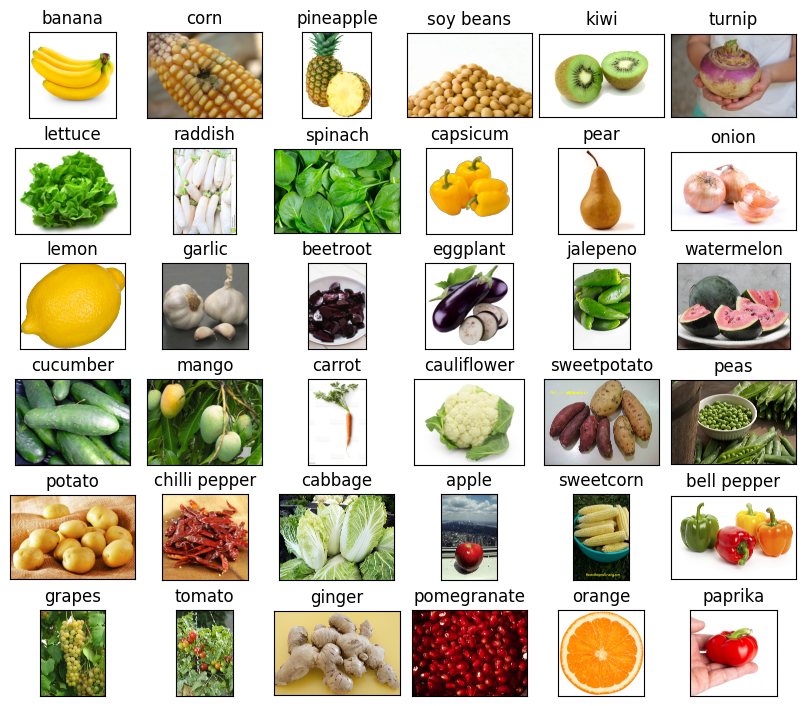

In [7]:
# Tạo một DataFrame với một Nhãn của mỗi category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Hiển thị một số hình ảnh của tập dữ liệu
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

# 2. Load the Images with a generator and Data Augmentation<a class="anchor" id="2"></a>

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3115 validated image filenames belonging to 36 classes.
Found 351 validated image filenames belonging to 36 classes.
Found 359 validated image filenames belonging to 36 classes.


In [9]:
# Tải mô hình đã được đào tạo trước
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

# 3. Train the model<a class="anchor" id="3"></a>

In [10]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)
model.save('model.h5')


Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.3686 - loss: 2.4962 - val_accuracy: 0.8661 - val_loss: 0.5005
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.8225 - loss: 0.5662 - val_accuracy: 0.8946 - val_loss: 0.3085
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.8743 - loss: 0.3635 - val_accuracy: 0.9316 - val_loss: 0.2372
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.9298 - loss: 0.2120 - val_accuracy: 0.9630 - val_loss: 0.1798
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9559 - loss: 0.1488 - val_accuracy: 0.9516 - val_loss: 0.1669


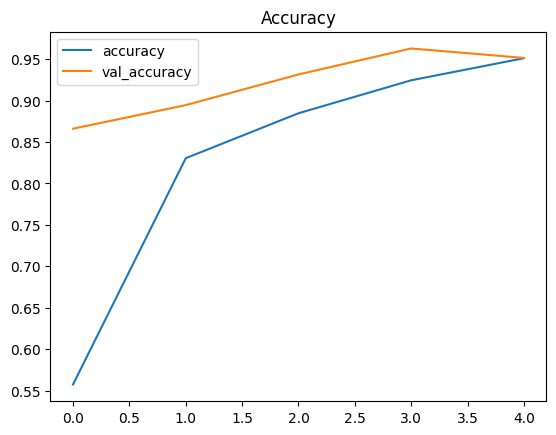

In [11]:
#biểu đồ trực quan giữa tập huấn luyện accuracy và tập xác thực val_accuracy
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

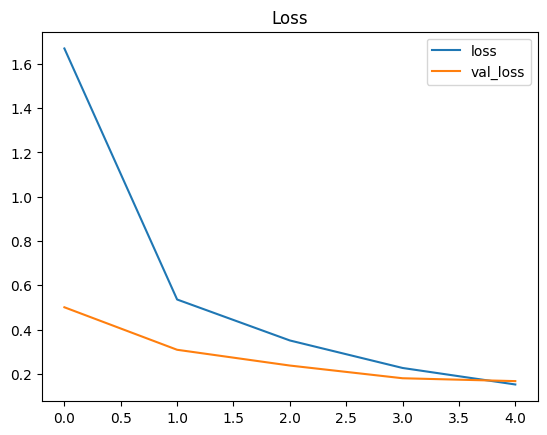

In [12]:
#loss (hàm mất mát trên tập huấn luyện) và val_loss (hàm mất mát trên tập xác thực)
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# 4. Visualize the result<a class="anchor" id="4"></a>

In [13]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step


In [14]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 95.26%


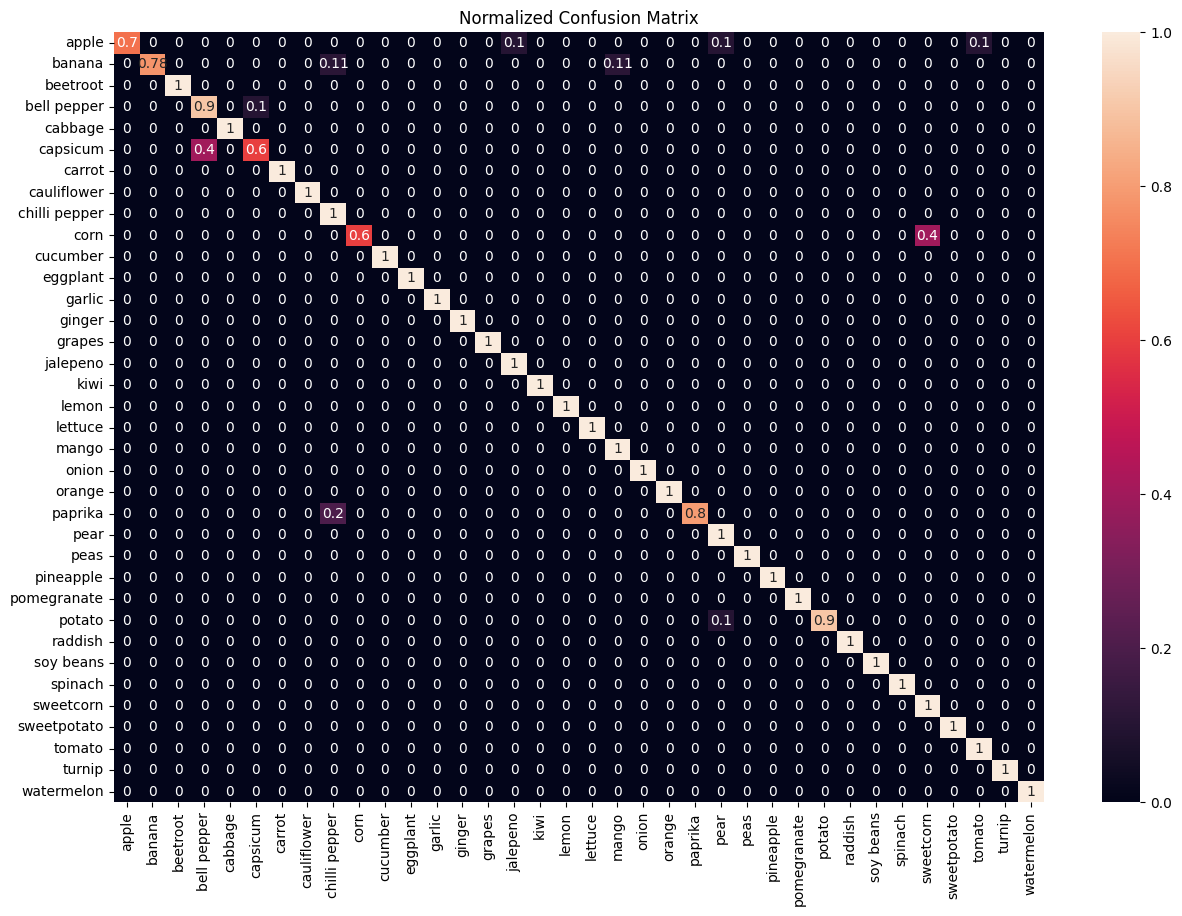

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

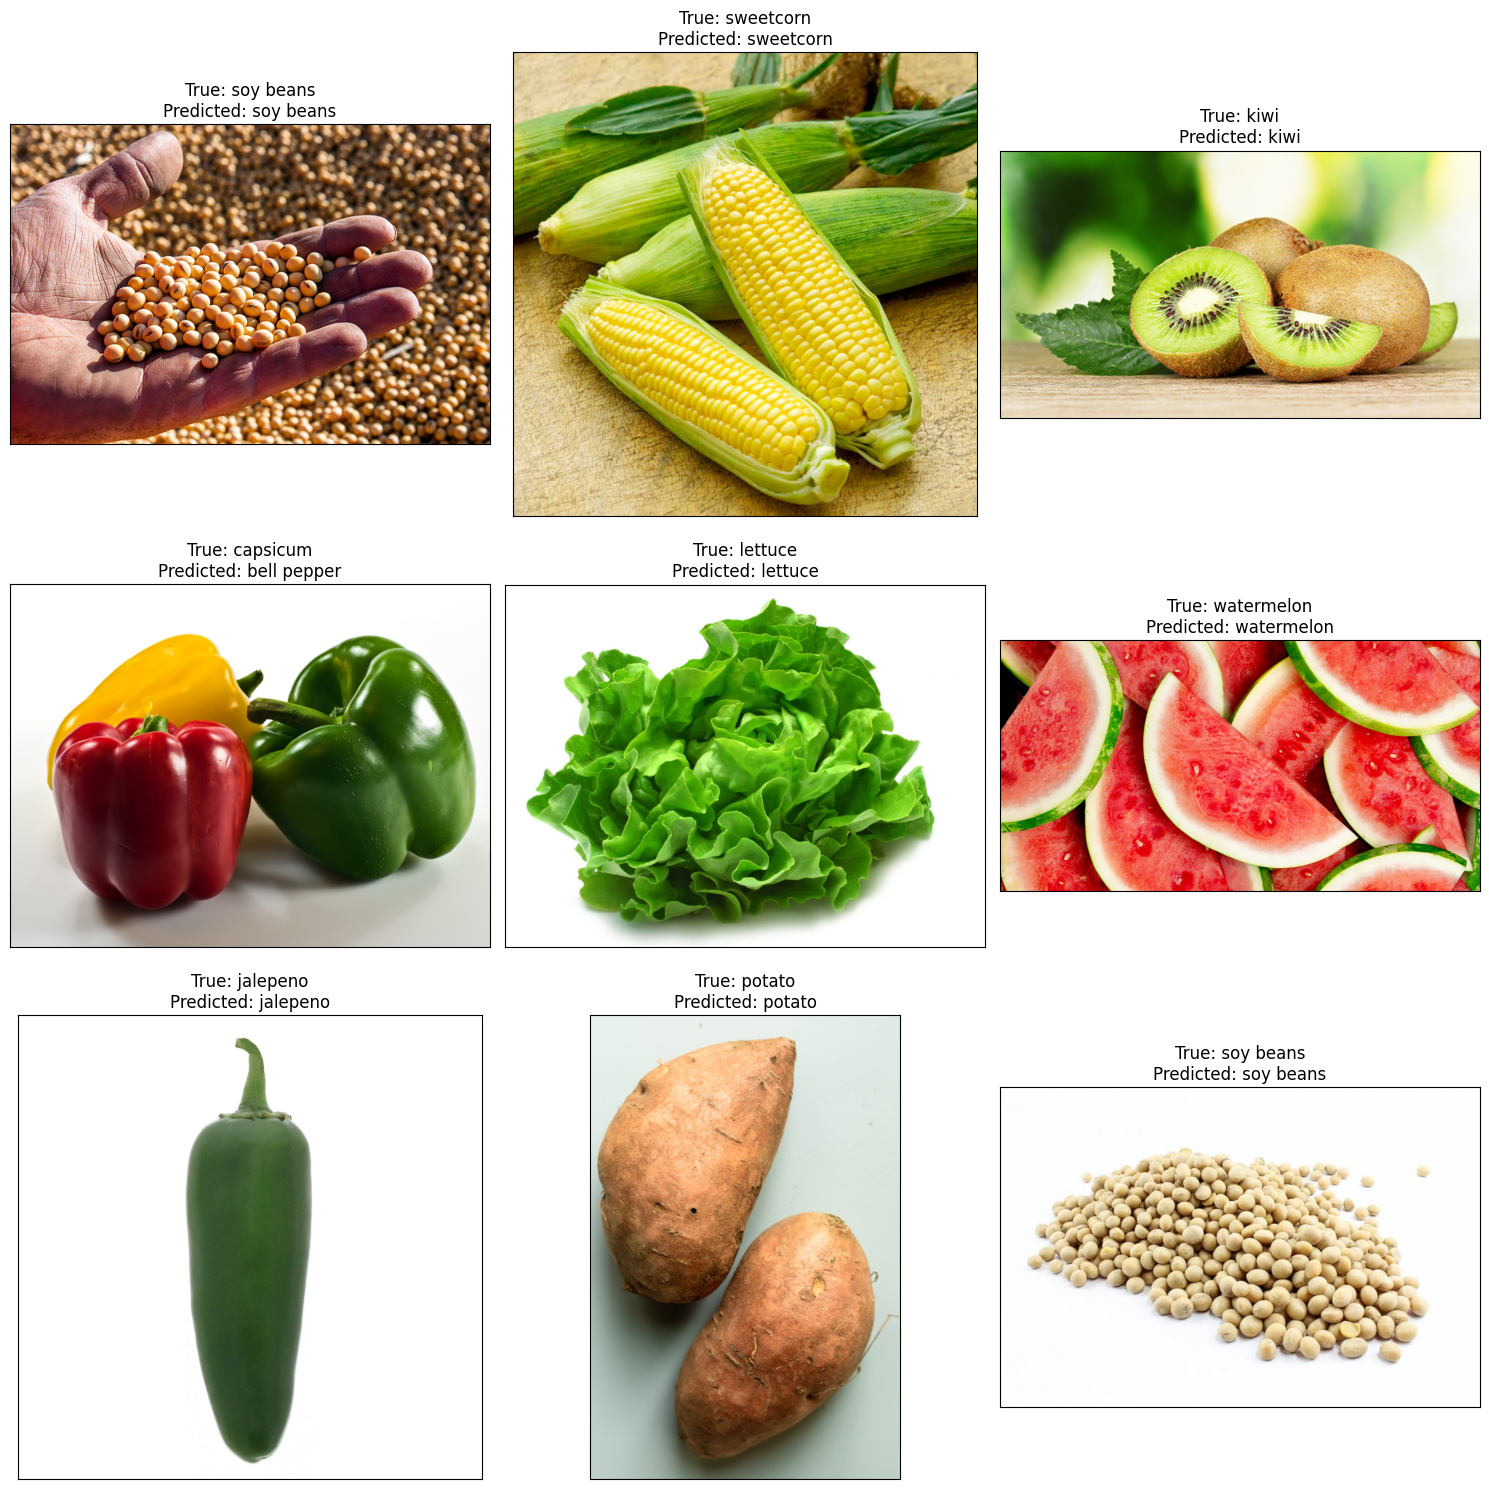

In [16]:
# Hiển thị một số hình ảnh của tập dữ liệu với nhãn thực tế và nhãn dự đoán
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

## 5. Class activation heatmap for image classification<a class="anchor" id="5"></a>
### Grad-CAM class activation visualization
*Code adapted from keras.io*

In [17]:
import matplotlib.cm as cm

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].ativation = None